# Plane wave expansion with Autograd

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume import PlaneWaveExp, Circle, ShapesLayer, Lattice
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

## Define 2D photonic crystal waveguide

Here, we will optimize the dispersion of a 2D PhC waveguide. The underlying photonic crystal is similar to that in Chapter 5, Fig. 2 of "Photonic crystals: molding the flow of light", and has a broad band gap for TM-modes. The waveguide is introduced as a missing row of pillars. To have a sufficient number of free parameters, we take a supercell of size $5a$ in the propagation direction.

In [2]:
# PhC parameters
ra = 0.2     # pillar radius
eps_b = 1    # background permittivity
eps_c = 9    # pillar permittivity

# plane-wave expansion parameters
gmax = 2     # truncation of the plane-wave basis
Ny = 14      # Number of rows in the y-direction
Ny_opt = 3   # Number of rows in which the pillars will be modified
Nx = 5       # Supercell size in the x-direction

# Initialize a rectangular lattice
lattice = Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])

def wg_sc(dx, dy, dr):
    """Define the photonic crystal waveguide given shift parameters 
    dx, dy, and dr, for the 2*Nx*Ny_opt number of pillars that get shifted
    """
    # Initialize a layer and the positions of the pillars for the regular waveguide
    layer_wg = ShapesLayer(lattice, eps_b=eps_b)
    xc = []; yc = [] 
    for ih in range(Ny):
        if ih != Ny//2:
            for ix in range(-Nx//2+1, Nx//2+1):
                xc.append((ih%2)*0.5 + ix)
                yc.append((-Ny//2 + ih)*np.sqrt(3)/2)
    
    # Add all the pillars, taking care of the shifts
    for ih in range(1, Ny//2+1):
        nx1 = (Ny//2+ih-1)
        nx2 = (Ny//2-ih)
        if ih <= Ny_opt:
            # The ih row includes "optimization" pillars
            for ix in range(Nx):
                circ = Circle(x_cent=xc[nx1*Nx + ix] + dx[(ih-1)*Nx + ix],
                              y_cent=yc[nx1*Nx + ix] + dy[(ih-1)*Nx  + ix], 
                              r = ra + dr[(ih-1)*Nx + ix], eps=eps_c)
                layer_wg.add_shape(circ)
                circ = Circle(x_cent=xc[nx2*Nx + ix] + dx[(ih-1+Ny_opt)*Nx  + ix],
                              y_cent=yc[nx2*Nx + ix] + dy[(ih-1+Ny_opt)*Nx  + ix], 
                              r = ra + dr[(ih-1+Ny_opt)*Nx + ix], eps=eps_c)
                layer_wg.add_shape(circ)
        else:
            # The ih row includes just regular pillars
            for ix in range(Nx):
                circ = Circle(x_cent = xc[nx2*Nx + ix], y_cent=yc[nx2*Nx + ix], r=ra, eps=eps_c)
                layer_wg.add_shape(circ)
                if ih < Ny//2:
                    circ = Circle(x_cent = xc[nx1*Nx + ix], y_cent=yc[nx1*Nx + ix], r=ra, eps=eps_c)
                    layer_wg.add_shape(circ)
    
    # Construct and return a plane-wave expansion object
    return PlaneWaveExp(layer_wg, gmax=gmax)

We first simulate the starting (un-modified) waveguide. Notice that the Brillouin zone is folded five times in the $x$-direction. There is just a single guided band in the band-gap if the elementary cell is used.

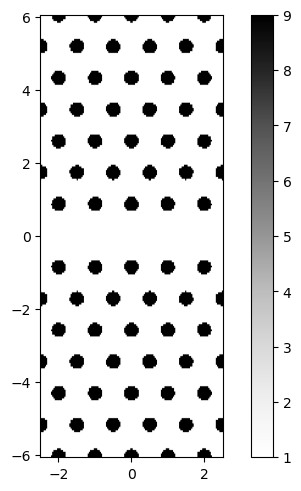

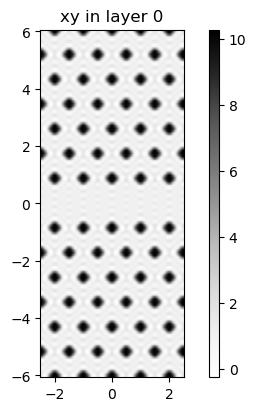

In [3]:
# Initialize zero shifts
dx0 = np.zeros((Nx*2*Ny_opt, ))
dy0 = np.zeros((Nx*2*Ny_opt, ))
dr0 = np.zeros((Nx*2*Ny_opt, ))

# Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
pwe0 = wg_sc(dx0, dy0, dr0)
legume.viz.eps(pwe0.layer, Nx=150, Ny=250, cbar=True)
legume.viz.eps_ft(pwe0, Nx=150, Ny=250, figsize = (2.5, 4))

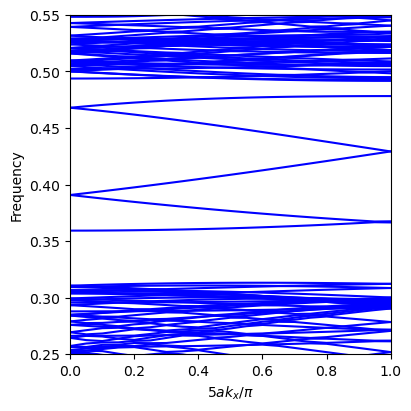

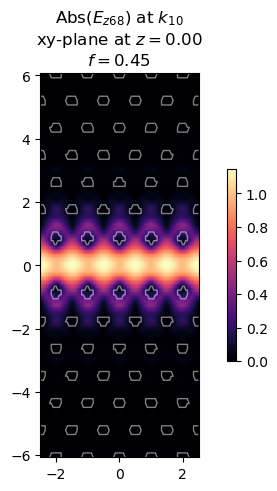

In [4]:
# Define a BZ path in kx and run the PWE
path = pwe0.layer.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [20])
pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

# Plot the (folded) waveguide bands 
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(4, 4))
ax.plot(pwe0.kpoints[0, :]*5/np.pi, pwe0.freqs, 'b')
ax.set_ylim([0.25, 0.55])
ax.set_xlim([0, pwe0.kpoints[0, -1]*5/np.pi])
ax.set_xlabel('$5a k_x/ \pi$')
ax.set_ylabel('Frequency')

# Plot the field of one of the waveguide modes using the in-built `legume` function
legume.viz.field(pwe0, field='e', kind=10, mind=Nx*(Ny-1) + 3, component='z', val='abs');

## Compute gradients

We can use `legume` and `autograd` to efficiently compute gradients of PWE simulations. We will define the objective function as the mean-squared error between one of the waveguided bands and a target band shape. Let's first illustrate this target.

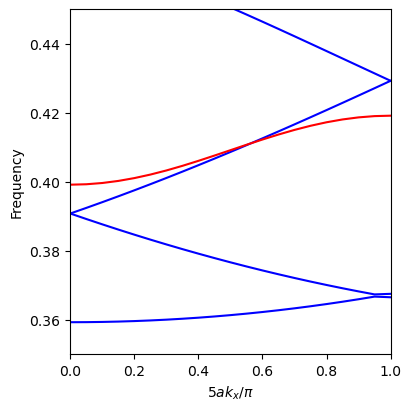

In [5]:
# Define a target band shape and which band we will try to optimize
kpts = path['kpoints'][0, :]
f_target = -0.01*np.cos(kpts*Nx) # Just a cosine target
b_target = Nx*Ny - 3             # Index of the middle waveguide band in the folded structure

# Plot the folded waveguide bands and the target shape centered at the target band
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(4, 4))
ax.plot(pwe0.kpoints[0, :]*5/np.pi, pwe0.freqs, 'b')
ax.plot(pwe0.kpoints[0, :]*5/np.pi, f_target + np.mean(pwe0.freqs[:, b_target]), 'r')
ax.set_ylim([0.35, 0.45])
ax.set_xlim([0, pwe0.kpoints[0, -1]*5/np.pi])
ax.set_xlabel('$5a k_x/ \pi$')
ax.set_ylabel('Frequency');

In [6]:
# Define the objective function for the target band shape
def of_sc(params):
    # Define shift parameters
    dx = params[0:Nx*2*Ny_opt]
    dy = params[Nx*2*Ny_opt:2*Nx*2*Ny_opt]
    dr = params[2*Nx*2*Ny_opt:]
    
    # Initialize and run the plane-wave expansion
    pwe = wg_sc(dx, dy, dr)
    pwe.run(pol='tm', kpoints=path['kpoints'], numeig=Ny*Nx+10)
    
    # Get the target band, ans shift by its mean value
    band = pwe.freqs[:, b_target]
    b_shift = band - npa.mean(band)
        
    # Return the MSE between the shifted band and the target
    return npa.sum(npa.square(b_shift - f_target))

We will first test the gradient computation. Note that `legume` (through `autograd`) computes the gradients efficiently, using one backpropagation to get the derivative of the objective w.r.t. *every* parameter simultaneously. Because of time considerations, for the numerical finite-difference check we will only pick one parameter at random. Also note that we initialize the parameters with some random small values, in order to break the high symmetry of the un-modified structure. 

In [7]:
# To compute gradients, we need to set the `legume` backend to 'autograd'
legume.set_backend('autograd')

# Initialize random starting parameters to break the high symmetry
dxrand = 0.01*np.random.randn(Nx*Ny_opt)
dx0 = np.hstack((dxrand, dxrand))
dyrand = 0.01*np.random.randn(Nx*Ny_opt)
dy0 = np.hstack((dyrand,-dyrand))
drrand = 0.01*np.random.randn(Nx*Ny_opt)
dr0 = np.hstack((drrand, drrand))
pstart = np.hstack((dx0, dy0, dr0))

# Choose one parameter index at random for the numerical check 
# We pick one of the dy-s because they have the largest gradient in the beginning
ind0 = np.random.randint(Nx*Ny_opt, 2*Nx*Ny_opt, 1)

# Compute the autograd gradients (NB: all at once!)
t = time.time()
grad_a = grad(of_sc)(pstart)
# Print the gradient w.r.t. the parameter index ind0
print("Autograd gradient:  %1.6f, computed in %1.4fs" %(grad_a[ind0], time.time() - t))

# Compute a numerical gradient for parameter ind0
t = time.time()
p_test = np.copy(pstart)
p_test[ind0] = p_test[ind0] + 1e-5 
grad_n = (of_sc(p_test) - of_sc(pstart))/1e-5
print("Numerical gradient: %1.6f, computed in %1.4fs" %(grad_n, time.time() - t))

print("Relative difference: %1.2e" %np.abs((grad_a[ind0] - grad_n)/grad_n))

Autograd gradient:  -0.000026, computed in 2.7420s
Numerical gradient: -0.000026, computed in 3.2668s
Relative difference: 2.40e-05


The two gradients match very well, and the `autograd` simulation took as much time to get *all* the derivatives as it took the numerical simulation time to get just one of the derivatives. The magic of reverse-mode automatic differentiation!

## Optimize the waveguide

For the optimization, we will use the `Minimize` class provided with `legume`, which implements either `adam` or `lbfgs` minimization. The `lbfgs` minimizer is just a wrapper around the `SciPy` implementation, and any external optimization function can also be combined with the gradient computation from `legume`. Note that `autograd` provides both a `grad` function as used above, and an `obj_and_grad` function that returns simultaneously the value and the gradient of the objective function, which can be useful for custom optimization functions.

In [8]:
# Initialize an optimization object
opt = Minimize(of_sc)

# Run the optimization
(p_opt, ofs1) = opt.lbfgs(pstart, Nepochs=10)

Epoch:    1/  10 | Duration:  14.66 secs | Objective: 1.654478e-05
Epoch:    2/  10 | Duration:   3.37 secs | Objective: 1.168233e-05
Epoch:    3/  10 | Duration:   3.26 secs | Objective: 4.554540e-06
Epoch:    4/  10 | Duration:   3.22 secs | Objective: 4.485529e-06
Epoch:    5/  10 | Duration:   3.24 secs | Objective: 4.424716e-06
Epoch:    6/  10 | Duration:   3.24 secs | Objective: 4.116053e-06
Epoch:    7/  10 | Duration:   3.24 secs | Objective: 3.654911e-06
Epoch:    8/  10 | Duration:   3.31 secs | Objective: 2.956595e-06
Epoch:    9/  10 | Duration:   3.23 secs | Objective: 1.932357e-06
Epoch:   10/  10 | Duration:   3.23 secs | Objective: 1.288668e-06


Finally let's plot the optiized band, and the underlying structure.

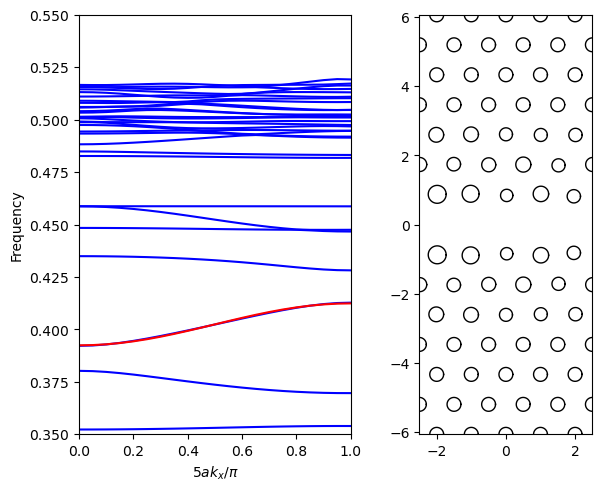

In [9]:
# Get the shifts from the optimized parameters
dx = p_opt[0:Nx*2*Ny_opt]
dy = p_opt[Nx*2*Ny_opt:2*Nx*2*Ny_opt]
dr = p_opt[2*Nx*2*Ny_opt:]

# Initialize and run the PWE with the optimized shifts
pwe = wg_sc(dx, dy, dr)
pwe.run(pol='tm', kpoints=path['kpoints'], numeig=Nx*Ny+25)

# Plot the waveguide bands and the target band
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].plot(pwe.kpoints[0, :]*5/np.pi, pwe.freqs, 'b')
ax[0].plot(pwe.kpoints[0, :]*5/np.pi, f_target + np.mean(pwe.freqs[:, b_target]), 'r')
ax[0].set_ylim([0.35, 0.55])
ax[0].set_xlim([0, pwe.kpoints[0, -1]*5/np.pi])
ax[0].set_xlabel('$5a k_x/ \pi$')
ax[0].set_ylabel('Frequency');

# Use an in-built legume method to plot the structure
legume.viz.shapes(pwe.layer, ax=ax[1])